In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

                                   0
ZVV 3 Zonen              2792.394976
ZVV 9-Pass Zürich        2876.794976
GA                       2900.000000
ZVV 1-2 Zone             2901.994976
ZVV 9-Pass (alle Zonen)  3012.594976
ZVV 4 Zonen              3050.594976
Half-Fare                3795.394976


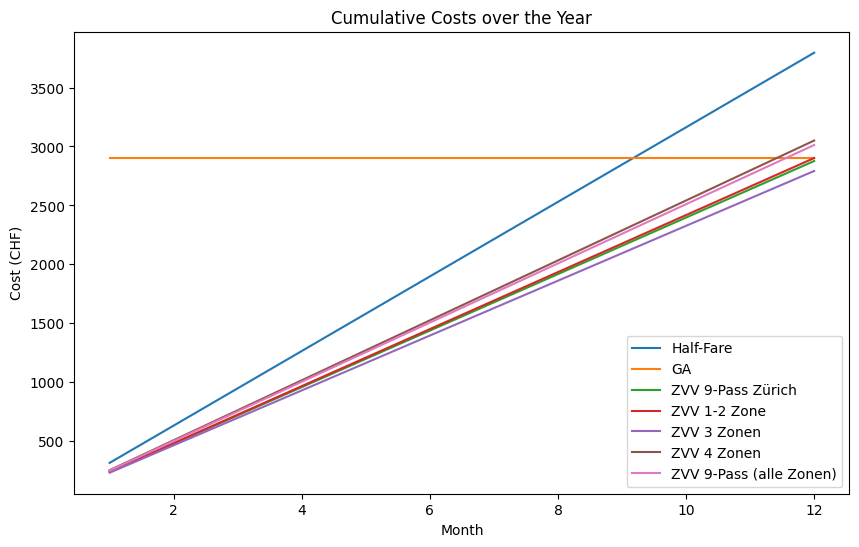

In [3]:
# Reload the data
df_travel_cards = pd.read_csv('Travel_Cards.csv')
df_travel_routes = pd.read_csv('Travel_routes.csv')

def convert_to_dict(costs):
    # Split the string into pairs of key-value
    items = costs.strip("[]").split("; ")
    # For each pair, split into key and value and strip the unnecessary characters
    items = [item.split(": ") for item in items]
    items = [(k.strip("'"), float(v)) for k, v in items]
    return dict(items)

# Convert 'Costs' only
df_travel_routes['Costs'] = df_travel_routes['Costs'].apply(convert_to_dict)

# Initialize a dictionary to store the monthly costs for each travel card
monthly_costs = {card: [0]*12 for card in df_travel_cards['Travel Card']}

# Iterate over each row in the travel routes dataframe
for i, row in df_travel_routes.iterrows():
    route_costs = row['Costs']
    times_per_month = row['How many times per month']
    included_cards = row['Included in Travel Card']

    # Calculate the monthly cost for each travel card
    for card in monthly_costs.keys():
        # The cost for the route is 0 if the travel card is included in the route
        if card in included_cards:
            cost = 0
        # Use the cost associated with the 'Half-Fare' card if 'GA' is the only included card
        elif included_cards == '[GA]':
            cost = route_costs.get('Half-Fare', 0)
        # Use the cost associated with the travel card, if it exists, or the cost associated with the 'Half-Fare' card, if it doesn't
        else:
            cost = route_costs.get(card, route_costs.get('Half-Fare', 0))

        # Add the cost for the route multiplied by the number of times it's taken per month to the monthly costs
        monthly_costs[card] = [x + cost * times_per_month for x in monthly_costs[card]]

# Add the cost of each travel card divided by 12 to the monthly costs for that card
for i, row in df_travel_cards.iterrows():
    card = row['Travel Card']
    cost = row['Cost (CHF)'] / 12  # Divide by 12 to get the monthly cost
    monthly_costs[card] = [x + cost for x in monthly_costs[card]]

# Calculate the cumulative costs
cumulative_costs = {card: np.cumsum(monthly_costs[card]) for card in monthly_costs.keys()}

# Get the total annual cost for each travel card as a dataframe
df_total_costs = pd.DataFrame({card: [cumulative_costs[card][-1]] for card in cumulative_costs.keys()})

# Sort the dataframe by the total annual cost
df_total_costs = df_total_costs.sort_values(by=0, axis=1)

# Flip the dataframe so that the travel cards are in the rows
df_total_costs = df_total_costs.transpose()

# Print the dataframe
print(df_total_costs)

# Adjust the cumulative costs for the GA card to reflect the total annual cost at the beginning of the year
cumulative_costs['GA'] = [df_travel_cards[df_travel_cards['Travel Card'] == 'GA']['Cost (CHF)'].values[0]] * 12

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the cumulative costs for each travel card
for card in cumulative_costs.keys():
    plt.plot(range(1, 13), cumulative_costs[card], label=card)

# Set the title and labels
plt.title('Cumulative Costs over the Year')
plt.xlabel('Month')
plt.ylabel('Cost (CHF)')
plt.legend()

# Show the plot
plt.show()

In [11]:
import plotly.graph_objects as go

# Initialize a dictionary to store the route costs for each travel card
route_costs = {card: {destination: 0 for destination in df_travel_routes['Destination']} for card in df_travel_cards['Travel Card']}

# Iterate over each row in the travel routes dataframe
for i, row in df_travel_routes.iterrows():
    destination = row['Destination']
    route_costs_row = row['Costs']
    times_per_month = row['How many times per month']
    included_cards = row['Included in Travel Card']

    # Calculate the route cost for each travel card
    for card in route_costs.keys():
        if card in included_cards:
            cost = 0
        elif included_cards == '[GA]':
            cost = route_costs_row.get('Half-Fare', 0)
        else:
            cost = route_costs_row.get(card, route_costs_row.get('Half-Fare', 0))
        route_costs[card][destination] += cost * times_per_month * 12

# All the costs from the route_costs dictionary can be made a bit cheaper due to a new offer: Half-fare plus. There are three options: you pay 800 and get 1000, 1500 get 2000 or pay 2100 and get 3000. We can make a switch case with the best fitting option for each card.
def half_fare_plus(cost):
    if cost < 1000:
        return cost * 800 / 1000
    elif cost < 2000:
        return cost * 1500 / 2000
    else:
        return cost * 2100 / 3000
    
# Apply the half_fare_plus function to all the costs in the route_costs dictionary
route_costs = {card: {destination: half_fare_plus(cost) for destination, cost in costs.items()} for card, costs in route_costs.items()}

# Get the card costs
card_costs = df_travel_cards.set_index('Travel Card')['Cost (CHF)'].to_dict()

# Calculate the total cost for each card
total_costs = {card: sum(route_costs[card].values()) + card_costs[card] for card in route_costs.keys()}

# Sort the travel cards by total cost
sorted_cards = sorted(total_costs.items(), key=lambda x: x[1])

# Get the cost of the cheapest card
cheapest_card_cost = sorted_cards[0][1]

# Plotting
fig = go.Figure()

for idx, destination in enumerate(df_travel_routes['Destination'].unique()):
    # create a list of costs per route for each sorted card
    costs_per_route = [route_costs[card][destination] for card, _ in sorted_cards]
    fig.add_trace(go.Bar(
        x=[card for card, _ in sorted_cards],
        y=costs_per_route,
        name=destination
    ))

# Add the costs of the cards themselves
fig.add_trace(go.Bar(
    x=[card for card, _ in sorted_cards],
    y=[card_costs[card] for card, _ in sorted_cards],
    name='Card Cost'
))

# Add the total costs of the cards as text annotations to the plot
for i, (card, total_cost) in enumerate(sorted_cards):
    fig.add_annotation(
        x=i,  # this is the index of the card in the sorted list
        y=total_cost + 100,  # this is the total cost of the card
        text=str(round(total_cost, 2)),
        showarrow=False
    )

    # Calculate the total route costs without the card cost for each card
    total_route_costs = {card: sum(route_costs[card].values()) for card in route_costs.keys()}

    # Add a red dot for the total route costs without the card cost
    fig.add_trace(go.Scatter(
        x=[card for card, _ in sorted_cards],
        y=[total_route_costs[card] for card, _ in sorted_cards],
        mode='markers',
        line=dict(color='red', width=2),
        showlegend=False  # Remove the legend for this trace
    ))

# Modify x-axis labels to include the difference to the cheapest card
xaxis_labels = [f"{card}<br>(+{round(total_cost - cheapest_card_cost, 2)}, CHF)" for card, total_cost in sorted_cards]

# Add the layout details
fig.update_layout(
    title='Annual Costs Breakdown for Each Travel Card',
    xaxis=dict(title="Travel Card", tickmode='array', tickvals=list(range(len(sorted_cards))), ticktext=xaxis_labels),
    yaxis_title="Cost (CHF)",
    barmode='stack'
)

fig.show()

# save the plot as a png with high resolution, 5000 by 2000 pixels
fig.write_image("annual_costs_breakdown.png", width=1000, height=500, scale=3)